In [1]:
# install networkx
# !pip install networkx
# install matplotlib
# !pip install matplotlib
# install numpy
# !pip install numpy
# install scipy
# !pip install scipy
# !pip install cvxpy

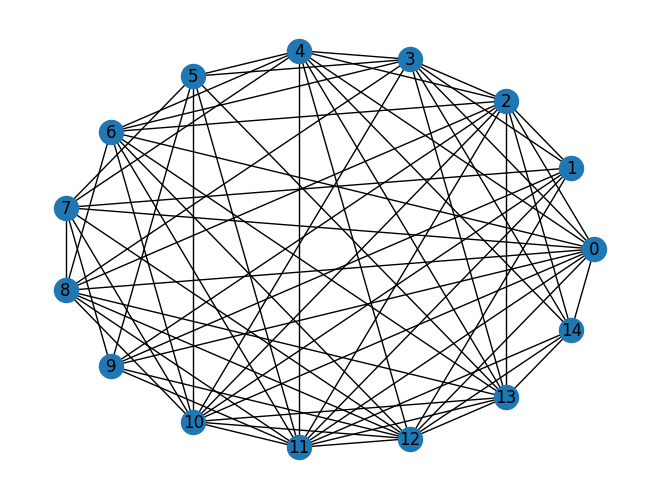

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Create a random graph with 10 nodes and 20 edges
G = nx.gnm_random_graph(15, 70)

# Draw the graph such that the nodes are arranged in a circle
nx.draw_circular(G, with_labels=True)
plt.show()

Best cut: [1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0]
Cost: 47


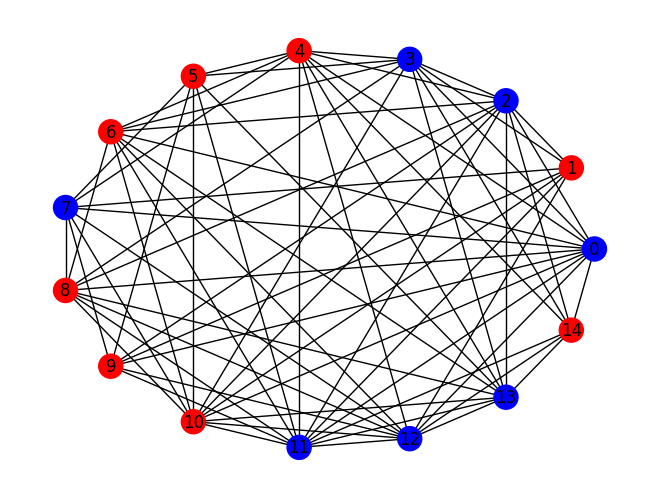

In [3]:
# compute max cut using brute force
def max_cut_brute_force(G):
    n = G.number_of_nodes()
    best_cost = 0
    best_cut = []
    for i in range(2**n):
        cut = [0]*n
        for j in range(n):
            cut[j] = (i // 2**j) % 2
        cost = 0
        for e in G.edges():
            if cut[e[0]] != cut[e[1]]:
                cost += 1
        if cost > best_cost:
            best_cost = cost
            best_cut = cut
    return best_cut, best_cost

cut, cost = max_cut_brute_force(G)
print('Best cut:', cut)
print('Cost:', cost)

# Draw the graph with the best cut
colors = ['r' if cut[i] == 0 else 'b' for i in range(G.number_of_nodes())]

nx.draw_circular(G, with_labels=True, node_color=colors)
plt.show()


In [4]:
# The polynomial-time approximation algorithm for Max-Cut with the best known approximation ratio 
# is a method by Goemans and Williamson using semidefinite programming 
# We shall implement this algorithm using the cvxpy library
import cvxpy as cp

def goemans_williamson_max_cut(G):
    # Number of nodes
    n = G.number_of_nodes()

    # Create a semidefinite variable for SDP relaxation
    # V will be the matrix of dot products, i.e., V[i, j] = v_i^T v_j
    V = cp.Variable((n, n), symmetric=True)
    
    # Objective: maximize sum of edge weights * (1 - <v_i, v_j>) / 2
    objective = cp.Maximize(
        cp.sum([1 * (1 - V[u, v]) / 2 for u, v in G.edges()])  # Initial 1 is the assumed weight of each edge
    )

    # Constraints: V should be positive semidefinite and diagonal elements must be 1
    constraints = [V >> 0]  # Positive semidefinite constraint
    constraints += [V[i, i] == 1 for i in range(n)]  # Diagonal elements must be 1 as v_i^T v_i = 1 (dot product of a vector with itself)

    # Define and solve the SDP
    prob = cp.Problem(objective, constraints)
    prob.solve()

    # Extract the matrix V
    V_value = V.value

    # Step 2: Randomly choose a hyperplane to perform rounding
    random_vector = np.random.randn(n)

    # Perform rounding
    cut = [0 if np.dot(V_value[i, :], random_vector) >= 0 else 1 for i in range(n)]

    # Compute the value of the cut
    cut_value = sum([1 for u, v in G.edges() if cut[u] != cut[v]])  # 1 is the assumed weight of each edge

    # Return the cut, which is a partition of the vertices
    return cut, cut_value

# Example usage
if __name__ == "__main__":
    # Create a weighted graph using networkx
    G = nx.Graph()

    # Add edges without weights
    G.add_edges_from([(0, 1), (0, 2), (1, 2), (1, 3), (2, 3), (2, 4), (3, 4), (3, 5), (4, 5)])
    
    # Run the Goemans-Williamson algorithm to get a Max-Cut
    cut = goemans_williamson_max_cut(G)

    print("Max-Cut Partition:", cut)


Max-Cut Partition: ([1, 1, 0, 1, 1, 0], 6)


Best cut: [1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0]
Cost: 14
Best cut: [0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
Cost: 14


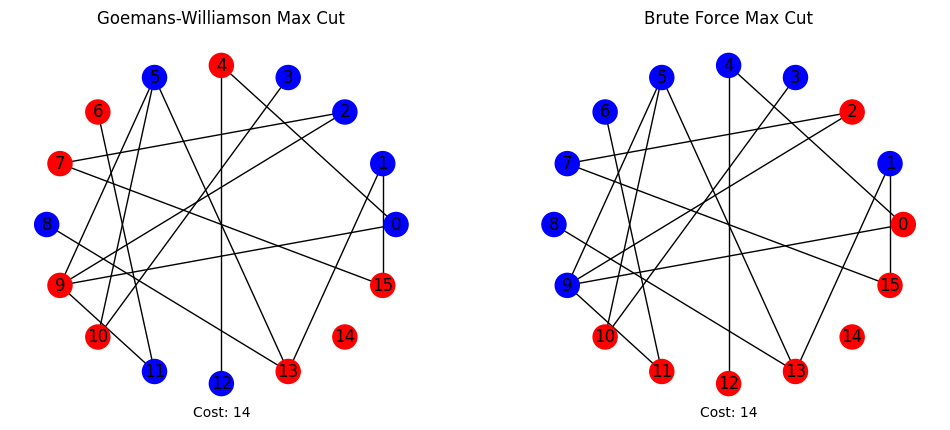

In [5]:
import matplotlib.pyplot as plt

# Create a random graph
G = nx.gnm_random_graph(16, 15)

# calculate goeman williamson max cut
cut, cost = goemans_williamson_max_cut(G)
print('Best cut:', cut)
print('Cost:', cost)

# Draw the graph with the best cut
colors = ['r' if cut[i] == 0 else 'b' for i in range(G.number_of_nodes())]

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the graph with the best cut in the first subplot
ax1.set_title('Goemans-Williamson Max Cut')
ax1.text(0.5, 0 , 'Cost: ' + str(cost), ha='center', transform=ax1.transAxes)
nx.draw_circular(G, with_labels=True, node_color=colors, ax=ax1)



# Use Brute force to calculate the max cut
cut, cost = max_cut_brute_force(G)
print('Best cut:', cut)
print('Cost:', cost)

# Draw the graph with the best cut in the second subplot
colors = ['r' if cut[i] == 0 else 'b' for i in range(G.number_of_nodes())]
ax2.set_title('Brute Force Max Cut')
ax2.text(0.5, 0 , 'Cost: ' + str(cost), ha='center', transform=ax2.transAxes)
bruteforce = nx.draw_circular(G, with_labels=True, node_color=colors, ax=ax2)

# Show the subplots
plt.show()


Best cut: ({0, 1, 6, 7, 10, 11, 12, 14}, {2, 3, 4, 5, 8, 9, 13, 15})
Cost: 61


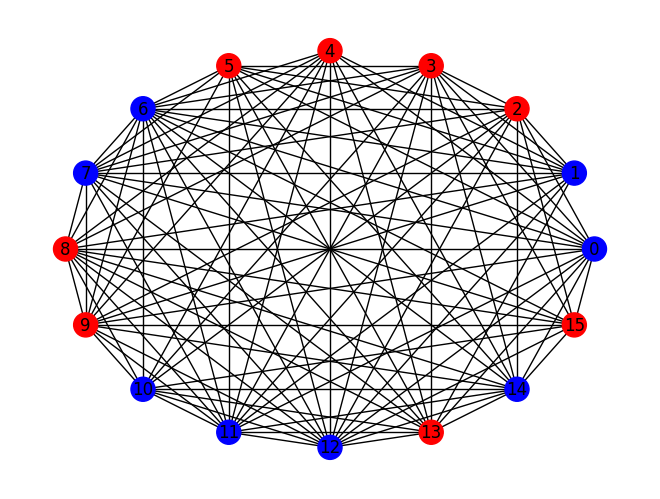

In [6]:
# Create a random graph
G = nx.gnm_random_graph(16, 100)
# calculate max cut using networkx one exchange heuristic
partition_set = []

cut_size, partition_new = nx.approximation.one_exchange(G,partition_set)

print('Best cut:', partition_new)
# print('Cost:', nx.algorithms.cuts.cut_size(G, partition_new[0]))
print('Cost:', cut_size)

# Draw the graph with the best cut
# Create a list of colors for the nodes initialised to red
colors = ['r'] * G.number_of_nodes()
for i in partition_new[0]:
    colors[i] = 'b'
    

nx.draw_circular(G, with_labels=True, node_color=colors)
plt.show()


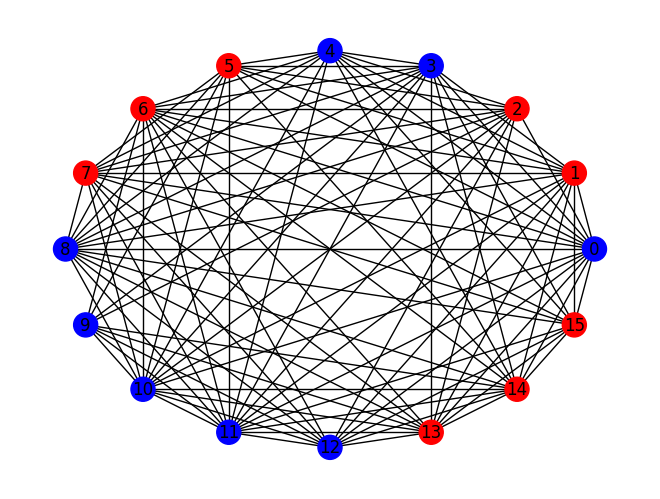

Cut size: 57


In [7]:
def one_exchange_approximation(G):
    n = G.number_of_nodes()
    partition_set = []

    # Calculate the best cut using the one exchange heuristic
    cut_size, partition_new = nx.approximation.one_exchange(G, partition_set)

    # Update the colors of the nodes based on the partition
    colors = [0] * n
    for i in partition_new[0]:
        colors[i] = 1

    return colors, cut_size

# Example usage
if __name__ == "__main__":
    # Create a random graph
    G = nx.gnm_random_graph(16, 100)

    # Run the one exchange approximation algorithm
    colors, cut_size = one_exchange_approximation(G)

    colors2 = ['r' if colors[i] == 0 else 'b' for i in range(G.number_of_nodes())]

    # Draw the graph with the best cut
    nx.draw_circular(G, with_labels=True, node_color=colors2)
    plt.show()
    print('Cut size:', cut_size)

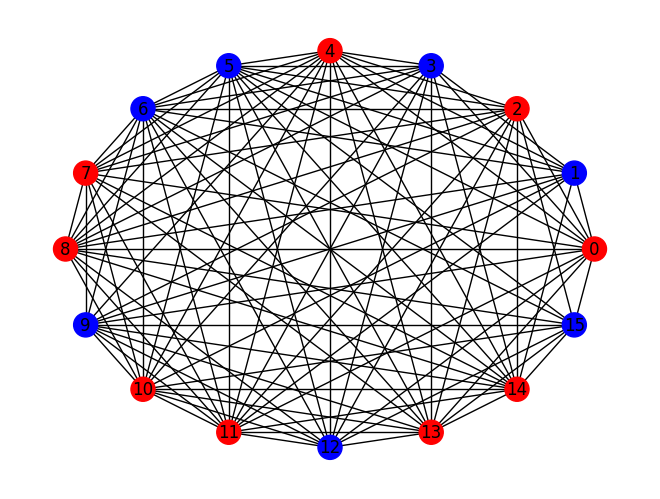

Cut size: 52


In [8]:
def randomized_cut(G, seed = None, p = 0.5, weight = None):
    n = G.number_of_nodes()
    cut_size, partition = nx.approximation.randomized_partitioning(G, seed, p, weight)
    return partition, cut_size

# Example usage
if __name__ == "__main__":
    # Create a random graph
    G = nx.gnm_random_graph(16, 100)

    # Run the randomized cut algorithm
    partition, cut_size = randomized_cut(G)

    # Update the colors of the nodes based on the partition
    colors = ['r' if i in partition[0] else 'b' for i in range(G.number_of_nodes())]

    # Draw the graph with the best cut
    nx.draw_circular(G, with_labels=True, node_color=colors)
    plt.show()
    print('Cut size:', cut_size)

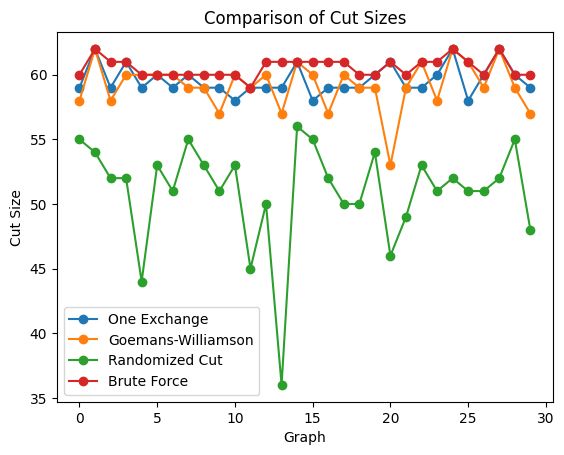

In [41]:
num_graphs = 30
graph_list = [nx.gnm_random_graph(16, 100) for _ in range(num_graphs)]

# Calculate the best cut for each graph using one exchange, Goemans-Williamson, and randomized cut
# Store the results in a dictionary
results = {}
for i, G in enumerate(graph_list):
    results['Graph ' + str(i + 1)] = {
        'One Exchange': one_exchange_approximation(G),
        'Goemans-Williamson': goemans_williamson_max_cut(G),
        'Randomized Cut': randomized_cut(G),
        'Brute Force': max_cut_brute_force(G)
    }

# Plot the results, draw a line connecting the cuts made using same method on different graphs
one_ex_cutsizes = [results['Graph ' + str(i + 1)]['One Exchange'][1] for i in range(num_graphs)]
gw_cutsizes = [results['Graph ' + str(i + 1)]['Goemans-Williamson'][1] for i in range(num_graphs)]
rand_cutsizes = [results['Graph ' + str(i + 1)]['Randomized Cut'][1] for i in range(num_graphs)]
bruteforce_cutsizes = [results['Graph ' + str(i + 1)]['Brute Force'][1] for i in range(num_graphs)]

# Creat a plot of all three plotted as lines
fig, ax = plt.subplots()
# put a marker on each point
ax.plot(one_ex_cutsizes, label='One Exchange', marker='o')
ax.plot(gw_cutsizes, label='Goemans-Williamson', marker='o')
ax.plot(rand_cutsizes, label='Randomized Cut', marker='o')
ax.plot(bruteforce_cutsizes, label='Brute Force', marker='o')
ax.set_xlabel('Graph')
ax.set_ylabel('Cut Size')
ax.set_title('Comparison of Cut Sizes')
ax.legend()
plt.show()


In [42]:
# # G1 = nx.gnm_random_graph(16, 100)
# # G2 = nx.gnm_random_graph(16, 100)
# # G3 = nx.gnm_random_graph(16, 100)

# # graph_list = [G1, G2, G3]

# num_graphs = 30
# graph_list = [nx.gnm_random_graph(16, 128) for _ in range(num_graphs)]

# # Calculate the best cut for each graph using one exchange, Goemans-Williamson, and randomized cut
# # Store the results in a dictionary
# results = {}
# for i, G in enumerate(graph_list):
#     results['Graph ' + str(i + 1)] = {
#         'One Exchange': one_exchange_approximation(G),
#         'Goemans-Williamson': goemans_williamson_max_cut(G),
#         'Randomized Cut': randomized_cut(G)
#     }

# # Plot the results, draw a line connecting the cuts made using same method on different graphs
# one_ex_cutsizes = [results['Graph ' + str(i + 1)]['One Exchange'][1] for i in range(num_graphs)]
# gw_cutsizes = [results['Graph ' + str(i + 1)]['Goemans-Williamson'][1] for i in range(num_graphs)]
# rand_cutsizes = [results['Graph ' + str(i + 1)]['Randomized Cut'][1] for i in range(num_graphs)]

# # Creat a plot of all three plotted as lines
# fig, ax = plt.subplots()
# # put a marker on each point
# ax.plot(one_ex_cutsizes, label='One Exchange', marker='o')
# ax.plot(gw_cutsizes, label='Goemans-Williamson', marker='o')
# ax.plot(rand_cutsizes, label='Randomized Cut', marker='o')
# ax.set_xlabel('Graph')
# ax.set_ylabel('Cut Size')
# ax.set_title('Comparison of Cut Sizes')
# ax.legend()
# plt.show()


One Exchange: [8, 8, 7, 8, 8, 7, 8, 8, 8, 7, 7, 7, 8, 7, 8, 7, 7, 8, 7, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 7]
Goemans-Williamson: [7, 8, 7, 7, 8, 7, 8, 7, 8, 6, 8, 8, 7, 6, 7, 7, 7, 7, 7, 7, 6, 7, 8, 8, 8, 8, 8, 8, 7, 7]
Brute Force: [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 8, 7, 8, 8, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8, 8, 8]


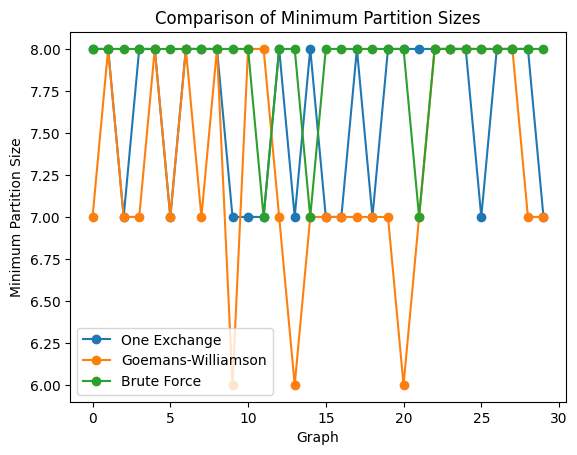

In [43]:
# let us analyze the solutions given by one_exchange, max_cut_brute_force and goemans_williamson_max_cut
# # on a random graph
# num_graphs = 30
# graph_list = [nx.gnm_random_graph(16, 61) for _ in range(num_graphs)]

# Calculate the best cut for each graph using one exchange, Goemans-Williamson, and randomized cut
# Store the results in a dictionary
# results = {}
# for i, G in enumerate(graph_list):
#     results['Graph ' + str(i + 1)] = {
#         'One Exchange': one_exchange_approximation(G),
#         'Goemans-Williamson': goemans_williamson_max_cut(G),
#         'Brute Force': max_cut_brute_force(G)
#     }

# Get the minimum of partition sizes for each method
one_ex_partitions = [results['Graph ' + str(i + 1)]['One Exchange'][0] for i in range(num_graphs)]
gw_partitions = [results['Graph ' + str(i + 1)]['Goemans-Williamson'][0] for i in range(num_graphs)]
bruteforce_partitions = [results['Graph ' + str(i + 1)]['Brute Force'][0] for i in range(num_graphs)]

# print('One Exchange:', one_ex_partitions[0])
# one_ex_min_partition_size = minimum of the size of 'r' and 'b' for each element in the partitions
one_ex_min_partition_size = [min(sum([1 for i in partition if i == 0]), sum([1 for i in partition if i == 1])) for partition in one_ex_partitions]
gw_min_partition_size = [min(sum([1 for i in partition if i == 0]), sum([1 for i in partition if i == 1])) for partition in gw_partitions]
bruteforce_min_partition_size = [min(sum([1 for i in partition if i == 0]), sum([1 for i in partition if i == 1])) for partition in bruteforce_partitions]

print('One Exchange:', one_ex_min_partition_size)
print('Goemans-Williamson:', gw_min_partition_size)
print('Brute Force:', bruteforce_min_partition_size)

# Creat a plot of all three plotted as lines
fig, ax = plt.subplots()
# put a marker on each point
ax.plot(one_ex_min_partition_size, label='One Exchange', marker='o')
ax.plot(gw_min_partition_size, label='Goemans-Williamson', marker='o')
ax.plot(bruteforce_min_partition_size, label='Brute Force', marker='o')
ax.set_xlabel('Graph')
ax.set_ylabel('Minimum Partition Size')
ax.set_title('Comparison of Minimum Partition Sizes')
ax.legend()
plt.show()



One Exchange: [91, 95, 90, 92, 92, 89, 97, 90, 94, 96, 90, 96, 91, 92, 93, 95, 90, 93, 93, 90, 95, 94, 91, 94, 93, 95, 91, 95, 92, 93]
Goemans-Williamson: [100, 100, 98, 96, 98, 98, 98, 95, 99, 98, 97, 98, 96, 91, 100, 99, 96, 99, 98, 98, 99, 94, 100, 99, 91, 97, 96, 100, 100, 94]


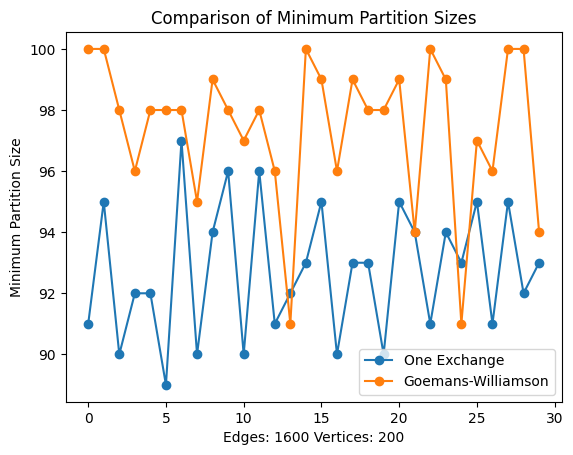

In [60]:
# let us analyze the solutions given by one_exchange, max_cut_brute_force and goemans_williamson_max_cut
# # on a random graph
num_graphs = 30
num_vertices = 200
num_edges = 1600
graph_list = [nx.gnm_random_graph(num_vertices,num_edges) for _ in range(num_graphs)]

# Calculate the best cut for each graph using one exchange, Goemans-Williamson, and randomized cut
# Store the results in a dictionary
results = {}
for i, G in enumerate(graph_list):
    results['Graph ' + str(i + 1)] = {
        'One Exchange': one_exchange_approximation(G),
        'Goemans-Williamson': goemans_williamson_max_cut(G),
    }

# Get the minimum of partition sizes for each method
one_ex_partitions = [results['Graph ' + str(i + 1)]['One Exchange'][0] for i in range(num_graphs)]
gw_partitions = [results['Graph ' + str(i + 1)]['Goemans-Williamson'][0] for i in range(num_graphs)]

# print('One Exchange:', one_ex_partitions[0])
# one_ex_min_partition_size = minimum of the size of 'r' and 'b' for each element in the partitions
one_ex_min_partition_size = [min(sum([1 for i in partition if i == 0]), sum([1 for i in partition if i == 1])) for partition in one_ex_partitions]
gw_min_partition_size = [min(sum([1 for i in partition if i == 0]), sum([1 for i in partition if i == 1])) for partition in gw_partitions]

print('One Exchange:', one_ex_min_partition_size)
print('Goemans-Williamson:', gw_min_partition_size)

# Creat a plot of all three plotted as lines
fig, ax = plt.subplots()
# put a marker on each point
ax.plot(one_ex_min_partition_size, label='One Exchange', marker='o')
ax.plot(gw_min_partition_size, label='Goemans-Williamson', marker='o')

# add number of vertices and edges to the xlabel
ax.set_xlabel('Edges: '+str(num_edges)+' Vertices: '+str(num_vertices))
ax.set_ylabel('Minimum Partition Size')
ax.set_title('Comparison of Minimum Partition Sizes')
ax.legend()
plt.show()



One Exchange: [141, 141, 141, 142, 142, 143, 138, 143, 136, 142, 139, 137, 144, 133, 141, 140, 141, 137, 142, 141, 139, 144, 139, 138, 145, 144, 142, 141, 144, 145]
Goemans-Williamson: [141, 147, 146, 141, 136, 144, 144, 138, 133, 144, 140, 143, 148, 135, 140, 142, 139, 139, 135, 140, 140, 143, 141, 144, 139, 143, 141, 139, 145, 137]


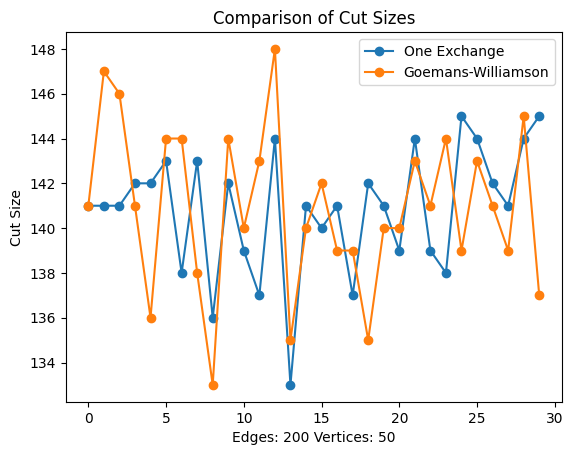

In [57]:
# let us analyze the solutions given by one_exchange, max_cut_brute_force and goemans_williamson_max_cut
# # on a random graph
num_graphs = 30
num_vertices = 50
num_edges = 200
graph_list = [nx.gnm_random_graph(num_vertices,num_edges) for _ in range(num_graphs)]

# Calculate the best cut for each graph using one exchange, Goemans-Williamson, and randomized cut
# Store the results in a dictionary
results = {}
for i, G in enumerate(graph_list):
    results['Graph ' + str(i + 1)] = {
        'One Exchange': one_exchange_approximation(G),
        'Goemans-Williamson': goemans_williamson_max_cut(G),
    }

# Get the minimum of partition sizes for each method
one_ex_partitions = [results['Graph ' + str(i + 1)]['One Exchange'][0] for i in range(num_graphs)]
gw_partitions = [results['Graph ' + str(i + 1)]['Goemans-Williamson'][0] for i in range(num_graphs)]

# print('One Exchange:', one_ex_partitions[0])
# one_ex_min_partition_size = minimum of the size of 'r' and 'b' for each element in the partitions
one_ex_cutsizes = [results['Graph ' + str(i + 1)]['One Exchange'][1] for i in range(num_graphs)]
gw_cutsizes = [results['Graph ' + str(i + 1)]['Goemans-Williamson'][1] for i in range(num_graphs)]

print('One Exchange:', one_ex_cutsizes)
print('Goemans-Williamson:', gw_cutsizes)

# Creat a plot of both as lines
fig, ax = plt.subplots()
# put a marker on each point
ax.plot(one_ex_cutsizes, label='One Exchange', marker='o')
ax.plot(gw_cutsizes, label='Goemans-Williamson', marker='o')

# add number of vertices and edges to the xlabel
ax.set_xlabel('Edges: '+str(num_edges)+' Vertices: '+str(num_vertices))
ax.set_ylabel('Cut Size')
ax.set_title('Comparison of Cut Sizes')
ax.legend()
plt.show()




In [ ]:
# Try modifying the one exchange method for maxcut
# Check the performance of these two algorithms in actual large graphs and also the trend in quality of solution depending on sparsity of the graph

Modified One-Exchange


In [9]:
from networkx.utils.decorators import not_implemented_for, py_random_state

__all__ = ["randomized_partitioning", "one_exchange"]

@not_implemented_for("directed")
@not_implemented_for("multigraph")
@py_random_state(1)
def randomized_partitioning(G, seed=None, p=0.5, weight=None):
    """Compute a random partitioning of the graph nodes and its cut value.

    A partitioning is calculated by observing each node
    and deciding to add it to the partition with probability `p`,
    returning a random cut and its corresponding value (the
    sum of weights of edges connecting different partitions).

    Parameters
    ----------
    G : NetworkX graph

    seed : integer, random_state, or None (default)
        Indicator of random number generation state.
        See :ref:`Randomness<randomness>`.

    p : scalar
        Probability for each node to be part of the first partition.
        Should be in [0,1]

    weight : object
        Edge attribute key to use as weight. If not specified, edges
        have weight one.

    Returns
    -------
    cut_size : scalar
        Value of the minimum cut.

    partition : pair of node sets
        A partitioning of the nodes that defines a minimum cut.


    Raises
    ------
    NetworkXNotImplemented
        If the graph is directed or is a multigraph.
    """
    cut = {node for node in G.nodes() if seed.random() < p}
    cut_size = nx.algorithms.cut_size(G, cut, weight=weight)
    partition = (cut, G.nodes - cut)
    return cut_size, partition




def _swap_node_partition(cut, node):
    return cut - {node} if node in cut else cut.union({node})


@not_implemented_for("directed")
@not_implemented_for("multigraph")
@py_random_state(2)
# def mod_one_exchange(G, initial_cut=None, seed=None, weight=None):
#     """Modified version of one exchange algorithm for computing a maximum cut.
#     Instead of repeating the process till no improvement can be made, it stops after
#     no improvement can be made and partitions are roughly equal in size."""

#     """Compute a partitioning of the graphs nodes and the corresponding cut value.

#     Use a greedy one exchange strategy to find a locally maximal cut
#     and its value, it works by finding the best node (one that gives
#     the highest gain to the cut value) to add to the current cut
#     and repeats this process until no improvement can be made.

#     Parameters
#     ----------
#     G : networkx Graph
#         Graph to find a maximum cut for.

#     initial_cut : set
#         Cut to use as a starting point. If not supplied the algorithm
#         starts with an empty cut.

#     seed : integer, random_state, or None (default)
#         Indicator of random number generation state.
#         See :ref:`Randomness<randomness>`.

#     weight : object
#         Edge attribute key to use as weight. If not specified, edges
#         have weight one.

#     Returns
#     -------
#     cut_value : scalar
#         Value of the maximum cut.

#     partition : pair of node sets
#         A partitioning of the nodes that defines a maximum cut.

#     Raises
#     ------
#     NetworkXNotImplemented
#         If the graph is directed or is a multigraph.
#     """
#     if initial_cut is None:
#         initial_cut = set()
#     cut = set(initial_cut)
#     current_cut_size = nx.algorithms.cut_size(G, cut, weight=weight)
#     num_iters_max = G.number_of_nodes()
#     while True and num_iters_max > 0:
#         num_iters_max -= 1
#         nodes = list(G.nodes())
#         # Shuffling the nodes ensures random tie-breaks in the following call to max
#         seed.shuffle(nodes)
#         best_node_to_swap = max(
#             nodes,
#             key=lambda v: nx.algorithms.cut_size(
#                 G, _swap_node_partition(cut, v), weight=weight
#             ),
#             default=None,
#         )
#         potential_cut = _swap_node_partition(cut, best_node_to_swap)
#         potential_cut_size = nx.algorithms.cut_size(G, potential_cut, weight=weight)

#         partition1size = len(potential_cut)
#         partition2size = len(G.nodes) - partition1size
#         threshold = 1
        
#         if potential_cut_size > current_cut_size :
#             cut = potential_cut
#             current_cut_size = potential_cut_size
#         elif ((current_cut_size-potential_cut_size)<threshold and abs(partition1size - partition2size) > 1):
#             cut = potential_cut
#             current_cut_size = potential_cut_size
#         else:
#             break
    

#     partition = (cut, G.nodes - cut)
#     return current_cut_size, partition

def mod_one_exchange(G, initial_cut=None, seed=None, weight=None):
    """Modified version of one exchange algorithm for computing a maximum cut.
    Instead of repeating the process till no improvement can be made, it stops after
    no improvement can be made and partitions are roughly equal in size."""

    """Compute a partitioning of the graphs nodes and the corresponding cut value.

    Use a greedy one exchange strategy to find a locally maximal cut
    and its value, it works by finding the best node (one that gives
    the highest gain to the cut value) to add to the current cut
    and repeats this process until no improvement can be made.

    Parameters
    ----------
    G : networkx Graph
        Graph to find a maximum cut for.

    initial_cut : set
        Cut to use as a starting point. If not supplied the algorithm
        starts with an empty cut.

    seed : integer, random_state, or None (default)
        Indicator of random number generation state.
        See :ref:`Randomness<randomness>`.

    weight : object
        Edge attribute key to use as weight. If not specified, edges
        have weight one.

    Returns
    -------
    cut_value : scalar
        Value of the maximum cut.

    partition : pair of node sets
        A partitioning of the nodes that defines a maximum cut.

    Raises
    ------
    NetworkXNotImplemented
        If the graph is directed or is a multigraph.
    """
    if initial_cut is None:
        initial_cut = set()
    cut = set(initial_cut)
    current_cut_size = nx.algorithms.cut_size(G, cut, weight=weight)
    num_iters_max = G.number_of_nodes()
    iterations = 0
    while True and num_iters_max > 0:
    # while True:
        iterations += 1
        num_iters_max -= 1
        nodes = list(G.nodes())
        # Shuffling the nodes ensures random tie-breaks in the following call to max
        seed.shuffle(nodes)
        best_node_to_swap = max(
            nodes,
            key=lambda v: nx.algorithms.cut_size(
                G, _swap_node_partition(cut, v), weight=weight
            ),
            default=None,
        )
        prev_min_part_size = min(len(cut), len(G.nodes) - len(cut))
        potential_cut = _swap_node_partition(cut, best_node_to_swap)
        potential_cut_size = nx.algorithms.cut_size(G, potential_cut, weight=weight)

        potential_min_part_size = min(len(potential_cut), len(G.nodes) - len(potential_cut))
        threshold = 1
        
        if potential_cut_size > current_cut_size :
            cut = potential_cut
            current_cut_size = potential_cut_size
        elif ((current_cut_size-potential_cut_size)<threshold and potential_min_part_size - prev_min_part_size > 0):
            cut = potential_cut
            current_cut_size = potential_cut_size
        else:
            break
    

    partition = (cut, G.nodes - cut)
    return current_cut_size, partition

In [10]:
def mod_one_exchange_approximation(G):
    n = G.number_of_nodes()
    partition_set = []

    # Calculate the best cut using the one exchange heuristic
    cut_size, partition_new = mod_one_exchange(G, partition_set)

    # Update the colors of the nodes based on the partition
    colors = [0] * n
    for i in partition_new[0]:
        colors[i] = 1

    return colors, cut_size

In [15]:
# Use the modified one exchange algorithm to calculate the max cut and compare it with the original one exchange algorithm and the Goemans-Williamson algorithm
num_graphs = 50
num_vertices = 50
num_edges = 200
graph_list = [nx.gnm_random_graph(num_vertices,num_edges) for _ in range(num_graphs)]

# Calculate the best cut for each graph using one exchange, Goemans-Williamson, and randomized cut
# Store the results in a dictionary
results = {}
for i, G in enumerate(graph_list):
    results['Graph ' + str(i + 1)] = {
        'One Exchange': one_exchange_approximation(G),
        'Modified One Exchange': mod_one_exchange_approximation(G),
        'Goemans-Williamson': goemans_williamson_max_cut(G),
    }

# Get the minimum of partition sizes for each method
one_ex_partitions = [results['Graph ' + str(i + 1)]['One Exchange'][0] for i in range(num_graphs)]
mod_one_ex_partitions = [results['Graph ' + str(i + 1)]['Modified One Exchange'][0] for i in range(num_graphs)]
gw_partitions = [results['Graph ' + str(i + 1)]['Goemans-Williamson'][0] for i in range(num_graphs)]

# print('One Exchange:', one_ex_partitions[0])
# one_ex_min_partition_size = minimum of the size of 'r' and 'b' for each element in the partitions

one_ex_min_partition_size = [min(sum([1 for i in partition if i == 0]), sum([1 for i in partition if i == 1])) for partition in one_ex_partitions]
mod_one_ex_min_partition_size = [min(sum([1 for i in partition if i == 0]), sum([1 for i in partition if i == 1])) for partition in mod_one_ex_partitions]
gw_min_partition_size = [min(sum([1 for i in partition if i == 0]), sum([1 for i in partition if i == 1])) for partition in gw_partitions]

one_ex_cutsizes = [results['Graph ' + str(i + 1)]['One Exchange'][1] for i in range(num_graphs)]
mod_one_ex_cutsizes = [results['Graph ' + str(i + 1)]['Modified One Exchange'][1] for i in range(num_graphs)]
gw_cutsizes = [results['Graph ' + str(i + 1)]['Goemans-Williamson'][1] for i in range(num_graphs)]


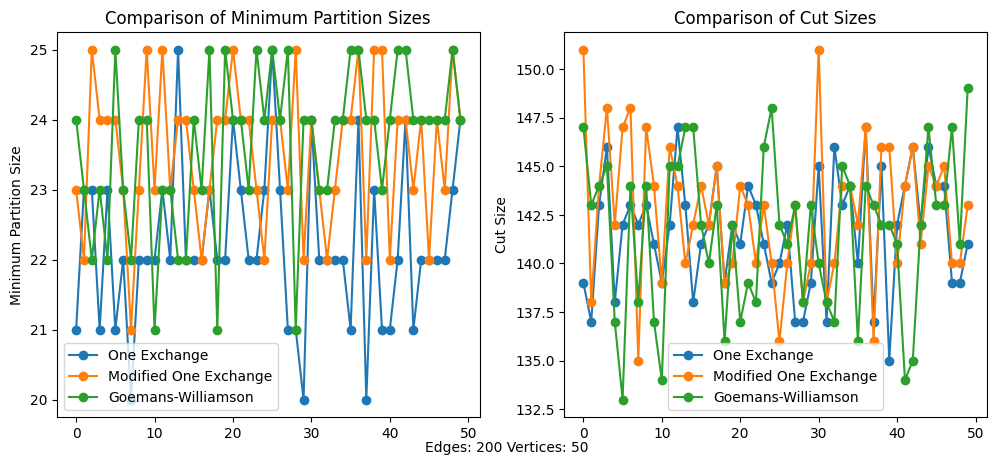

In [16]:
# Create 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the minimum partition sizes in the first subplot
ax1.plot(one_ex_min_partition_size, label='One Exchange', marker='o')
ax1.plot(mod_one_ex_min_partition_size, label='Modified One Exchange', marker='o')
ax1.plot(gw_min_partition_size, label='Goemans-Williamson', marker='o')

# Add edges and vertices to the xlabel
ax1.set_ylabel('Minimum Partition Size')
ax1.set_title('Comparison of Minimum Partition Sizes')
ax1.legend()

# Plot the cut sizes in the second subplot
ax2.plot(one_ex_cutsizes, label='One Exchange', marker='o')
ax2.plot(mod_one_ex_cutsizes, label='Modified One Exchange', marker='o')
ax2.plot(gw_cutsizes, label='Goemans-Williamson', marker='o')

# Add edges and vertices to the xlabel
ax2.set_ylabel('Cut Size')
ax2.set_title('Comparison of Cut Sizes')
ax2.legend()

# Add edges and vertices to the xlabel of whole figure
fig.text(0.5, 0.04, 'Edges: '+str(num_edges)+' Vertices: '+str(num_vertices), ha='center')

plt.show()

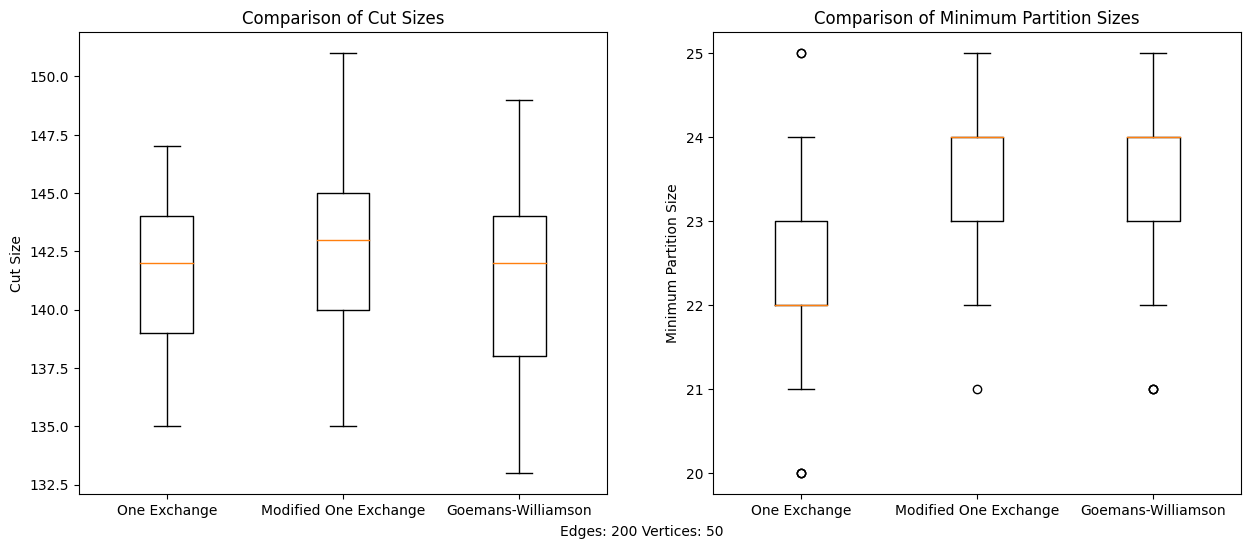

In [17]:
# Make a boxplot of cut sizes and partition sizes for the three algorithms

fig, ax = plt.subplots(1, 2, figsize=(15,6))

# Create a boxplot of the cut sizes
ax[0].boxplot([one_ex_cutsizes, mod_one_ex_cutsizes, gw_cutsizes])
ax[0].set_xticklabels(['One Exchange', 'Modified One Exchange', 'Goemans-Williamson'])
ax[0].set_ylabel('Cut Size')
ax[0].set_title('Comparison of Cut Sizes')

# Create a boxplot of the partition sizes
ax[1].boxplot([one_ex_min_partition_size, mod_one_ex_min_partition_size, gw_min_partition_size])
ax[1].set_xticklabels(['One Exchange', 'Modified One Exchange', 'Goemans-Williamson'])
ax[1].set_ylabel('Minimum Partition Size')
ax[1].set_title('Comparison of Minimum Partition Sizes')

# Mention the number of edges and vertices in the xlabel
fig.text(0.5, 0.04, 'Edges: '+str(num_edges)+' Vertices: '+str(num_vertices), ha='center')

plt.show()